###Cloning Repositories and Installing Dependencies

In [1]:
import os
# Set environment variable to avoid interactive timezone prompt during install
os.environ['DEBIAN_FRONTEND']='noninteractive'

print("Cloning StyleGAN2-ADA PyTorch repository...")
# Use --depth 1 for a shallow clone if you only need the latest code
!git clone --depth 1 https://github.com/NVlabs/stylegan2-ada-pytorch.git

print("\nInstalling dependencies...")
# Install necessary libraries using pip
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

print("\nSetup cell complete.")

Cloning StyleGAN2-ADA PyTorch repository...
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.

Installing dependencies...

Setup cell complete.


###Downloading Pre-trained StyleGAN2 512x512 FFHQ Model

In [2]:
import os
print("Downloading pre-trained StyleGAN2 FFHQ 512x512 model...")

# Define directory to save the model
# Saving it inside the cloned repo helps keep things organized
pretrained_dir = "stylegan2-ada-pytorch/pretrained"
os.makedirs(pretrained_dir, exist_ok=True)

# Define the URL for the specific model
# Found via NVlabs documentation/model zoo links
model_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl" # URL for 512x512 FFHQ model
model_path = os.path.join(pretrained_dir, "stylegan2-ffhq-512x512.pkl")

# Download using wget command directly
# The -c option allows resuming if the download is interrupted
print(f"Attempting download from {model_url} to {model_path}")
!wget -c -O "{model_path}" "{model_url}"

# Verify download
if os.path.exists(model_path) and os.path.getsize(model_path) > 1000000: # Check if file exists and is reasonably large
    print(f"\nModel downloaded successfully to {model_path}")
else:
    print(f"\nERROR: Model download failed or file is too small. Check URL or network connection.")
    # Optionally raise an error: raise RuntimeError("Model download failed")

Attempting download from https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl to stylegan2-ada-pytorch/pretrained/stylegan2-ffhq-512x512.pkl
--2025-05-06 19:36:46--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.203.101.202, 35.85.181.62
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.203.101.202|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xfiles.ngc.nvidia.com/org/nvidia/team/research/models/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl?ssec-algo=AES256&ssec-key=FW%2BNZC7KpZnNzvqGiN4KKJt5qvFj8y3fpATRRkq%2Fu1um469MQSRpCa%2BVmE8cAFpW8Y3qm%2BQbqe3tmyHq1OaKNPICUU0WtTUX3TID6bq%2Bf1GJMgum5XI9ejaS9%2BX38bGS3o%2B0DOMNHbrqxRYeOeF8gKXn0LwomImDvHITbw%2FNew0JHZFHIRCv2A6y1s4SbWwMywdbh20He%2B4wUJ%2F6hzO2RF0TO22DjWCC72m4aZ14dSRhEnwQroBLvRqWvUDTDEThpXLkgkx%2FKACnC8s0ftabQhk

###Loading the StyleGAN2 Generator Model

In [3]:
import sys
import torch
import pickle
import os # Need os module for abspath

# --- Add repo to sys.path using ABSOLUTE path ---
repo_path = './stylegan2-ada-pytorch' # Relative path
abs_repo_path = os.path.abspath(repo_path) # Get absolute path (e.g., /content/stylegan2-ada-pytorch)
print(f"Absolute path being added to sys.path: {abs_repo_path}")

if abs_repo_path not in sys.path:
    sys.path.insert(0, abs_repo_path)
    print(f"Added {abs_repo_path} to sys.path")
else:
    print("Path already in sys.path")

# --- Verify sys.path ---
import pprint
print("\nVerifying sys.path before import:")
pprint.pprint(sys.path)
print("-" * 20)

# --- Now try importing and loading ---
try:
    import dnnlib # Should find it now in the absolute path
    import legacy # Should find it now in the absolute path
    print("\nSuccessfully imported dnnlib and legacy.")

    print("Loading StyleGAN2 Generator...")
    network_pkl = os.path.join(abs_repo_path, "pretrained", "stylegan2-ffhq-512x512.pkl") # Use absolute path for consistency
    # network_pkl = "stylegan2-ada-pytorch/pretrained/stylegan2-ffhq-512x512.pkl" # Or keep relative if preferred, should work now

    # Define device (should be available from previous parts, e.g., cuda:0)
    if 'device' not in locals():
         device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
         print(f"Device was not set, detected: {device}")

    print(f"Loading network from {network_pkl}...")
    with dnnlib.util.open_url(network_pkl) as f:
        G_stylegan = legacy.load_network_pkl(f)['G_ema'].to(device)

    print("\nStyleGAN2 Generator (G_ema) loaded successfully.")
    print(f"Model is on device: {next(G_stylegan.parameters()).device}")

    # Print some info about the loaded generator
    print(f"Input latent z dimension (G_stylegan.z_dim): {G_stylegan.z_dim}")
    print(f"Input label c dimension (G_stylegan.c_dim): {G_stylegan.c_dim}")
    print(f"Output resolution (G_stylegan.img_resolution): {G_stylegan.img_resolution}")
    print(f"Number of output channels (G_stylegan.img_channels): {G_stylegan.img_channels}")

except ModuleNotFoundError as e:
     print(f"\nERROR: Import STILL failed even after adding absolute path: {e}")
     print("The next step would be to try restarting the runtime.")
except FileNotFoundError:
    print(f"ERROR: Model file not found at {network_pkl}.")
    print("Please ensure Cell 2 downloaded the model correctly.")
except Exception as e:
    print(f"ERROR loading StyleGAN model: {e}")

Absolute path being added to sys.path: /content/stylegan2-ada-pytorch
Added /content/stylegan2-ada-pytorch to sys.path

Verifying sys.path before import:
['/content/stylegan2-ada-pytorch',
 '/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython']
--------------------

Successfully imported dnnlib and legacy.
Loading StyleGAN2 Generator...
Device was not set, detected: cuda:0
Loading network from /content/stylegan2-ada-pytorch/pretrained/stylegan2-ffhq-512x512.pkl...

StyleGAN2 Generator (G_ema) loaded successfully.
Model is on device: cuda:0
Input latent z dimension (G_stylegan.z_dim): 512
Input label c dimension (G_stylegan.c_dim): 0
Output resolution (G_stylegan.img_resolution): 512
Number of output channels (G_stylegan.img_channels): 3


###Loading OpenAI's CLIP Model

In [4]:
import torch
import os
import subprocess # To help capture pip install output if needed

# --- Install OpenAI CLIP package ---
print("Installing OpenAI CLIP package...")
# Using subprocess to potentially capture output better in some environments
install_process = subprocess.run(['pip', 'install', 'git+https://github.com/openai/CLIP.git'], capture_output=True, text=True)
if install_process.returncode == 0:
    print("CLIP installation successful.")
    # print(install_process.stdout) # Optionally print stdout
else:
    print(f"CLIP installation failed. Error:\n{install_process.stderr}")
    # Optionally raise an error if installation fails
    # raise RuntimeError("CLIP installation failed.")

# --- Load CLIP Model ---
try:
    import clip
    print("\nAvailable CLIP models:", clip.available_models())

    # Define device (should be available from previous setup)
    if 'device' not in locals():
         device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
         print(f"Device was not set, detected: {device}")
    else:
         print(f"Using device: {device}")


    # Load the ViT-B/32 model. This will download weights if not cached.
    # It returns the model itself and a function to preprocess images for CLIP.
    model_name = "ViT-B/32"
    print(f"\nLoading CLIP model: {model_name}...")
    clip_model, clip_preprocess = clip.load(model_name, device=device)

    # Set model to evaluation mode (important for consistency, disables dropout etc.)
    clip_model.eval()

    print(f"\nCLIP model ({model_name}) loaded successfully.")
    print(f"CLIP model is on device: {next(clip_model.parameters()).device}") # Verify device
    print("clip_model and clip_preprocess variables are now ready.")

except ImportError:
    print("\nERROR: Failed to import CLIP. Was the installation successful?")
except Exception as e:
    print(f"\nERROR loading CLIP model: {e}")

# Example of the preprocess function signature (for reference)
# print("\nCLIP Preprocess info:")
# print(clip_preprocess)

Installing OpenAI CLIP package...
CLIP installation successful.

Available CLIP models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Using device: cuda:0

Loading CLIP model: ViT-B/32...

CLIP model (ViT-B/32) loaded successfully.
CLIP model is on device: cuda:0
clip_model and clip_preprocess variables are now ready.


### Basic StyleGAN Operations & Latent Space Exploration

Generating 4 random images using StyleGAN2 (512x512)...
Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Image generation complete.


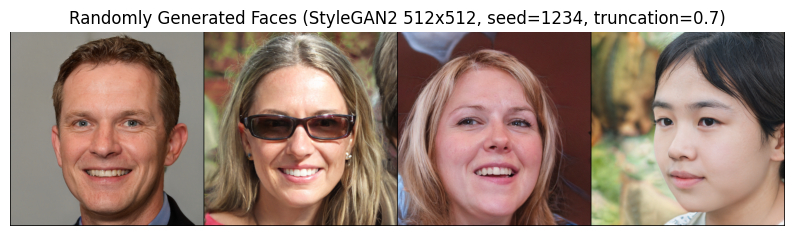

In [5]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# --- Generate Random Samples from StyleGAN ---

# Parameters
num_images_to_generate = 4 # How many images to generate in this batch
seed = 1234 # Set a seed for reproducibility of noise
truncation_psi = 0.7 # Truncation psi (0.5-0.8 typically good quality, 1.0 more diversity)
noise_mode = 'const' # Use constant noise for synthesis layers

# Ensure G_stylegan and device are available from the previous cell
if 'G_stylegan' not in locals():
    print("ERROR: G_stylegan not found. Please run the model loading cell first.")
else:
    try:
        print(f"Generating {num_images_to_generate} random images using StyleGAN2 (512x512)...")

        # Set seed for reproducibility
        torch.manual_seed(seed)

        # Generate latent codes (z) on the correct device
        # G_stylegan.z_dim should be 512 as printed earlier
        latents_z = torch.randn([num_images_to_generate, G_stylegan.z_dim], device=device)

        # Generate images - StyleGAN takes z, optional class label c (None here), and truncation/noise args
        # Use no_grad() as we don't need gradients for inference
        with torch.no_grad():
            # Make sure G_stylegan is in eval mode if it matters (usually safe for synthesis)
            # G_stylegan.eval()
            generated_images = G_stylegan(latents_z, None, truncation_psi=truncation_psi, noise_mode=noise_mode)

        print("Image generation complete.")

        # --- Visualize the Generated Images ---
        plt.figure(figsize=(10, 10)) # Adjust figure size as needed
        plt.axis("off")
        plt.title(f"Randomly Generated Faces (StyleGAN2 512x512, seed={seed}, truncation={truncation_psi})")

        # Post-process for display:
        # 1. Clamp output to [-1, 1] just in case
        # 2. Shift from [-1, 1] to [0, 1] for displaying/saving
        # 3. Use make_grid
        # 4. Transpose dimensions for matplotlib
        processed_images = (generated_images.clamp(-1, 1) + 1) / 2 # [-1,1] -> [0,1]
        grid = vutils.make_grid(processed_images, padding=2, normalize=False) # Already normalized [0,1]
        plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0))) # Convert to HWC format for display
        plt.show()

    except Exception as e:
        print(f"An error occurred during image generation or visualization: {e}")

###Latent Space Interpolation

Generating interpolation sequence (8 steps) between seed 42 and 101...
Interpolation sequence generated.


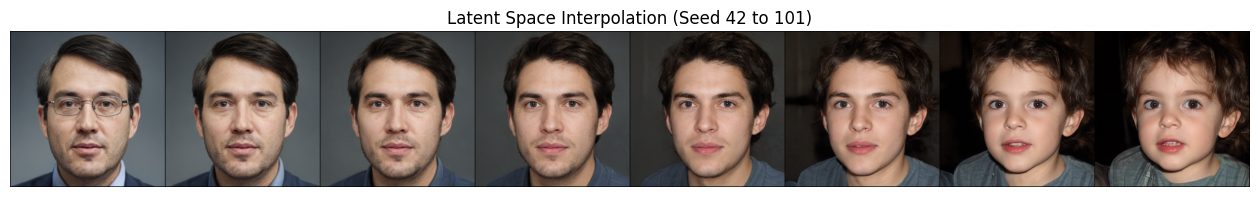

In [6]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# --- Latent Space Interpolation ---

# Parameters
seed1 = 42  # Seed for the starting face's noise
seed2 = 101 # Seed for the ending face's noise
num_steps = 8 # Number of steps (images) in the interpolation sequence
truncation_psi = 0.7 # Truncation psi (apply to w vectors)
noise_mode = 'const'

# Ensure G_stylegan and device are available
if 'G_stylegan' not in locals():
    print("ERROR: G_stylegan not found. Please run the model loading cell first.")
else:
    try:
        print(f"Generating interpolation sequence ({num_steps} steps) between seed {seed1} and {seed2}...")

        # Set seeds for reproducibility
        torch.manual_seed(seed1)
        z1 = torch.randn([1, G_stylegan.z_dim], device=device) # Generate first latent z
        torch.manual_seed(seed2)
        z2 = torch.randn([1, G_stylegan.z_dim], device=device) # Generate second latent z

        # Map z to intermediate latent space W
        # Use no_grad() as mapping and synthesis are inference steps
        with torch.no_grad():
            # G_stylegan.mapping takes z and optional class label c (None)
            # Returns w in shape [batch_size, num_ws, w_dim]
            # G_stylegan.num_ws is the number of layers the w is broadcast to (e.g., 14 for 512)
            w1 = G_stylegan.mapping(z1, None, truncation_psi=truncation_psi)
            w2 = G_stylegan.mapping(z2, None, truncation_psi=truncation_psi)

            # Interpolation weights (from 0.0 to 1.0)
            interpolation_alphas = torch.linspace(0, 1, num_steps, device=device)

            generated_images_list = []
            for alpha in interpolation_alphas:
                # Linear interpolation in W space
                # w = (1 - alpha) * w1 + alpha * w2 # Manual lerp
                w_interpolated = torch.lerp(w1, w2, alpha) # Use torch.lerp

                # Synthesize image from interpolated w
                # G_stylegan.synthesis takes w and noise_mode
                img = G_stylegan.synthesis(w_interpolated, noise_mode=noise_mode)
                generated_images_list.append(img)

            # Combine images into a single tensor batch for make_grid
            generated_images = torch.cat(generated_images_list, dim=0)

        print("Interpolation sequence generated.")

        # --- Visualize the Interpolation Sequence ---
        plt.figure(figsize=(16, 4)) # Adjust figure size for sequence
        plt.axis("off")
        plt.title(f"Latent Space Interpolation (Seed {seed1} to {seed2})")

        # Post-process for display
        processed_images = (generated_images.clamp(-1, 1) + 1) / 2
        # Display images in a row using make_grid
        grid = vutils.make_grid(processed_images, nrow=num_steps, padding=2, normalize=False)
        plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
        plt.show()

    except Exception as e:
        print(f"An error occurred during interpolation or visualization: {e}")
        import traceback
        traceback.print_exc()

###Basic Latent Space Manipulation (Attribute Editing)

Editing face (seed=42) from 'photo of a young face' towards 'photo of a an old face' with strength 5...
Image editing complete.


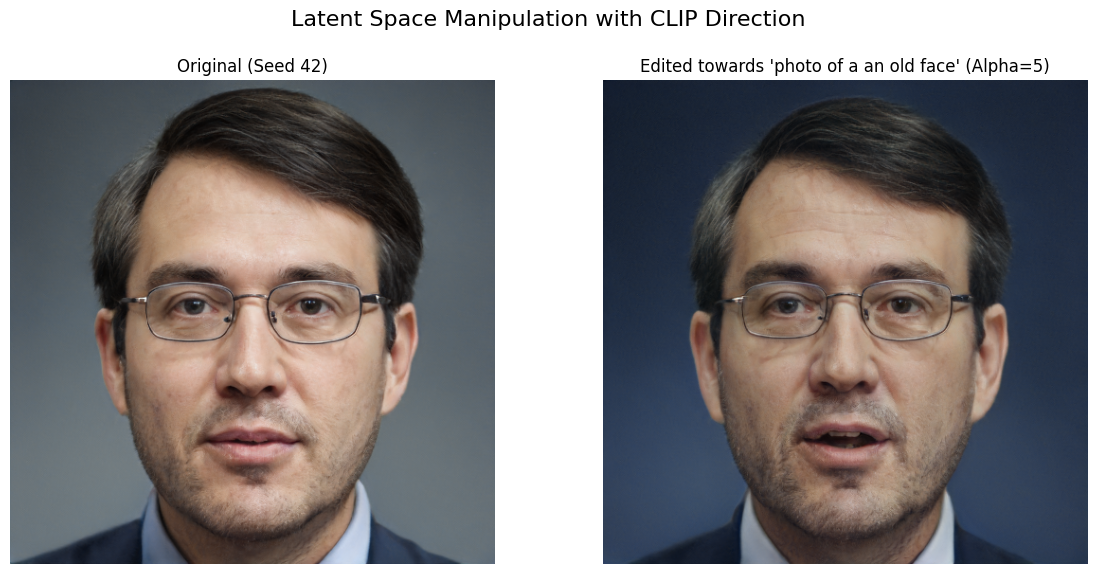

In [7]:
import torch
import clip
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image # For potential display adjustments

# --- Latent Space Manipulation using CLIP Directions ---

# Parameters
seed = 42 # Use the same seed as the start of the interpolation, or a new one
text_neutral = "photo of a young face" # Neutral description
text_target = "photo of a an old face" # Target description (e.g., "face with glasses", "old face", "face with beard")
edit_strength_alpha = 5 # How strongly to apply the edit (can be positive or negative, needs tuning)

truncation_psi = 0.7 # Use the same truncation as before for consistency
noise_mode = 'const'

# Ensure G_stylegan, clip_model, device are available
if 'G_stylegan' not in locals() or 'clip_model' not in locals():
    print("ERROR: G_stylegan or clip_model not found. Load models first.")
else:
    try:
        print(f"Editing face (seed={seed}) from '{text_neutral}' towards '{text_target}' with strength {edit_strength_alpha}...")

        # --- Generate Starting Image ---
        torch.manual_seed(seed)
        z = torch.randn([1, G_stylegan.z_dim], device=device)
        with torch.no_grad():
            # Get the starting W vector
            w_start = G_stylegan.mapping(z, None, truncation_psi=truncation_psi)
            # Generate the starting image
            img_start = G_stylegan.synthesis(w_start, noise_mode=noise_mode)

        # --- Calculate CLIP Direction ---
        with torch.no_grad():
            # Tokenize text descriptions
            tokens_neutral = clip.tokenize([text_neutral]).to(device)
            tokens_target = clip.tokenize([text_target]).to(device)

            # Encode text to get embeddings
            embedding_neutral = clip_model.encode_text(tokens_neutral)
            embedding_target = clip_model.encode_text(tokens_target)

            # Normalize embeddings (important for cosine similarity math)
            embedding_neutral /= embedding_neutral.norm(dim=-1, keepdim=True)
            embedding_target /= embedding_target.norm(dim=-1, keepdim=True)

            # Calculate direction vector
            text_direction = embedding_target - embedding_neutral
            text_direction /= text_direction.norm(dim=-1, keepdim=True) # Normalize the direction vector

        # --- Apply Edit to W ---
        # w_start has shape [1, num_ws, w_dim]. text_direction has shape [1, embed_dim]
        # CLIP embed_dim might not equal StyleGAN w_dim (e.g., 512 vs 512 is common)
        # A common simplification is to add the direction to all layers of W
        # Note: More sophisticated methods exist (e.g., StyleCLIP, StyleMC)
        # Let's assume embed_dim == w_dim for ViT-B/32 and StyleGAN2 (both often 512)
        # We need to broadcast text_direction: [1, 512] -> [1, 1, 512] or apply carefully
        if w_start.shape[-1] == text_direction.shape[-1]:
             # Add direction scaled by alpha to all W layers
             # Unsqueeze direction to match W's layer dimension: [1, 512] -> [1, 1, 512]
             w_edited = w_start + edit_strength_alpha * text_direction.unsqueeze(1) # Add to the num_ws dimension
        else:
            print(f"Warning: W dimension ({w_start.shape[-1]}) and CLIP embedding dimension ({text_direction.shape[-1]}) differ.")
            print("Skipping edit application. More complex mapping needed.")
            w_edited = w_start # Keep original if dimensions mismatch

        # --- Generate Edited Image ---
        with torch.no_grad():
            img_edited = G_stylegan.synthesis(w_edited, noise_mode=noise_mode)

        print("Image editing complete.")

        # --- Visualize Original and Edited Images ---
        # Combine images for comparison
        images_to_show = [img_start, img_edited]
        titles = [f"Original (Seed {seed})", f"Edited towards '{text_target}' (Alpha={edit_strength_alpha})"]

        fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Create 1 row, 2 columns
        fig.suptitle('Latent Space Manipulation with CLIP Direction', fontsize=16)

        for i, img_tensor in enumerate(images_to_show):
             # Post-process for display
             processed_img = (img_tensor.clamp(-1, 1) + 1) / 2
             # Remove batch dimension, move to CPU, convert C H W -> H W C
             img_np = processed_img[0].permute(1, 2, 0).cpu().numpy()

             axes[i].imshow(img_np)
             axes[i].set_title(titles[i])
             axes[i].axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

    except Exception as e:
        print(f"An error occurred during manipulation or visualization: {e}")
        import traceback
        traceback.print_exc()

###CLIP-Guided Generation (Latent Optimization)

In [41]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import clip # Make sure clip is imported
from torchvision import transforms # For CLIP normalization

# --- Optimization Parameters ---
target_text = "a man yelling with anger" # <<< CHANGE THIS
n_steps = 200  # Number of optimization steps (adjust later, 100-300 is common)
learning_rate = 0.05 # Learning rate for optimizing the latent code w (can tune this)
seed_for_start_w = 42 # Seed for the initial latent code, can change

# Ensure G_stylegan, clip_model, clip_preprocess, device are available
if 'G_stylegan' not in locals() or 'clip_model' not in locals():
    print("ERROR: G_stylegan or clip_model not found. Load models first.")
else:
    # --- Prepare Target Text Embedding ---
    print(f"Encoding target text: '{target_text}'")
    with torch.no_grad():
        # Tokenize and encode text, move to device
        text_tokens = clip.tokenize([target_text]).to(device)
        target_text_embedding = clip_model.encode_text(text_tokens)
        # Normalize the embedding (important!)
        target_text_embedding = target_text_embedding / target_text_embedding.norm(dim=-1, keepdim=True)
    print("Text embedding ready.")

    # --- Get Initial Latent Code W ---
    # We start optimization from a specific point in the W space.
    # Here, we map a random z vector. Using w_avg is another option if available.
    torch.manual_seed(seed_for_start_w)
    z_start = torch.randn([1, G_stylegan.z_dim], device=device)
    with torch.no_grad():
        # Map z to w, using the same truncation as before for consistency
        w_initial = G_stylegan.mapping(z_start, None, truncation_psi=0.7)

    # Detach w from the mapping network's computation graph and enable gradient calculation
    # This 'w_opt' tensor is the variable we will optimize
    w_opt = w_initial.detach().clone()
    w_opt.requires_grad = True
    print(f"Initial w vector shape: {w_opt.shape}") # Should be [1, num_ws, w_dim]

    # --- Set up Optimizer for W ---
    # We use Adam to optimize the w_opt tensor directly
    optimizer_w = optim.Adam([w_opt], lr=learning_rate, betas=(0.9, 0.999))
    print("Optimizer for w vector created.")

    # --- Define CLIP Normalization ---
    # CLIP expects images normalized in a specific way (often ImageNet stats)
    # We'll apply this after generating & resizing the image from StyleGAN
    clip_normalize = transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073), # Specific CLIP values
        std=(0.26862954, 0.26130258, 0.27577711)  # Specific CLIP values
    )
    print("CLIP normalization transform ready.")

    print("\nSetup for optimization complete. Ready for the optimization loop.")

Encoding target text: 'a man yelling with anger'
Text embedding ready.
Initial w vector shape: torch.Size([1, 16, 512])
Optimizer for w vector created.
CLIP normalization transform ready.

Setup for optimization complete. Ready for the optimization loop.


###Mounting Google Drive

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Preparing DCGAN Influence

In [43]:
import torch
import torch.nn as nn # Make sure nn is imported
import clip # Make sure clip is imported
from torchvision import transforms # Make sure transforms is imported
import torch.nn.functional as F # For interpolate

# Define Generator Network (DCGAN architecture)
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        """
        Initializes the Generator network.
        Args:
            nz (int): Size of the latent z vector (input noise dimension). Default=100.
            ngf (int): Size of feature maps in generator. Default=64.
                         Relates to the depth/capacity of the network.
            nc (int): Number of channels in the output image. Default=3 (for RGB).
        """
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        # We construct the generator layer by layer using nn.Sequential.
        # Input is Z, going into a convolution
        # Output size calculation for ConvTranspose2d: H_out = (H_in - 1) * stride - 2 * padding + kernel_size
        self.main = nn.Sequential(
            # Input: latent vector z (nz x 1 x 1)
            # Layer 1: ConvTranspose2d, BatchNorm, ReLU
            # Output: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Layer 2: ConvTranspose2d, BatchNorm, ReLU
            # Input: (ngf * 8) x 4 x 4 -> Output: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Layer 3: ConvTranspose2d, BatchNorm, ReLU
            # Input: (ngf * 4) x 8 x 8 -> Output: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Layer 4: ConvTranspose2d, BatchNorm, ReLU
            # Input: (ngf * 2) x 16 x 16 -> Output: (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Layer 5: Output Layer - ConvTranspose2d, Tanh
            # Input: (ngf) x 32 x 32 -> Output: (nc) x 64 x 64
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Tanh activation scales the output to the range [-1, 1], matching our normalized input data.
        )

    def forward(self, input):
        """
        Defines the forward pass of the Generator.
        Args:
            input (Tensor): Input latent vector z, shape (batch_size, nz, 1, 1).
        Returns:
            Tensor: Generated image, shape (batch_size, nc, 64, 64).
        """
        return self.main(input)

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8), nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input): return self.main(input)
# --- End of Generator Class Definition ---


# --- Load Trained DCGAN Generator ---
dcgan_checkpoint_path = "/content/drive/MyDrive/FINAL_PROJECT/Saved_Model/dcgan_epoch_15.pth" # <<< --- CHANGE THIS PATH if needed
dcgan_nz = 100 # Latent size used for DCGAN training
dcgan_ngf = 64 # Feature maps used for DCGAN training
dcgan_nc = 3   # Output channels for DCGAN training

# Instantiate the DCGAN Generator model
netG_dcgan = Generator(nz=dcgan_nz, ngf=dcgan_ngf, nc=dcgan_nc).to(device)

# Load the checkpoint
if os.path.exists(dcgan_checkpoint_path):
    print(f"Loading DCGAN checkpoint: {dcgan_checkpoint_path}")
    checkpoint_dcgan = torch.load(dcgan_checkpoint_path, map_location=device)
    if 'netG_state_dict' in checkpoint_dcgan:
        netG_dcgan.load_state_dict(checkpoint_dcgan['netG_state_dict'])
        print("Loaded DCGAN Generator state dict.")
    else:
         raise ValueError("netG_state_dict not found in DCGAN checkpoint!")
    netG_dcgan.eval() # Set DCGAN generator to evaluation mode
else:
    raise FileNotFoundError(f"DCGAN Checkpoint not found at {dcgan_checkpoint_path}")


# --- Generate and Encode DCGAN Image ---
print("Generating reference image from trained DCGAN...")
with torch.no_grad():
    # Generate noise for DCGAN
    z_dcgan = torch.randn(1, dcgan_nz, 1, 1, device=device)
    # Generate the 64x64 image
    img_dcgan = netG_dcgan(z_dcgan) # Output range is [-1, 1]

    print("Encoding DCGAN image with CLIP...")
    # Preprocess DCGAN image for CLIP:
    # 1. Upsample from 64x64 to 224x224 (CLIP's expected input size)
    img_dcgan_clip_input = F.interpolate(img_dcgan, size=224, mode='bicubic', align_corners=False)
    # 2. Shift range from [-1, 1] to [0, 1]
    img_dcgan_clip_input = (img_dcgan_clip_input + 1) / 2
    # 3. Apply CLIP's specific normalization
    img_dcgan_clip_input = clip_normalize(img_dcgan_clip_input)

    # Encode the processed image
    embed_dcgan = clip_model.encode_image(img_dcgan_clip_input)
    # Normalize the embedding
    embed_dcgan = embed_dcgan / embed_dcgan.norm(dim=-1, keepdim=True)
    print("DCGAN reference embedding ready.")

# --- Define Loss Weights ---
w_text = 1.0   # Weight for the text similarity loss
w_dcgan = 0.1 # Weight for the DCGAN similarity loss (NEEDS TUNING - start small)

print(f"Loss weights: w_text={w_text}, w_dcgan={w_dcgan}")
print("\nSetup for DCGAN influence complete.")

Loading DCGAN checkpoint: /content/drive/MyDrive/FINAL_PROJECT/Saved_Model/dcgan_epoch_15.pth
Loaded DCGAN Generator state dict.
Generating reference image from trained DCGAN...
Encoding DCGAN image with CLIP...
DCGAN reference embedding ready.
Loss weights: w_text=1.0, w_dcgan=0.1

Setup for DCGAN influence complete.


###Optimization Loop

Starting optimization for 'a man yelling with anger'...
Optimizing w vector for 200 steps...


  0%|          | 0/200 [00:00<?, ?it/s]


Optimization finished.
Visualizing final result...


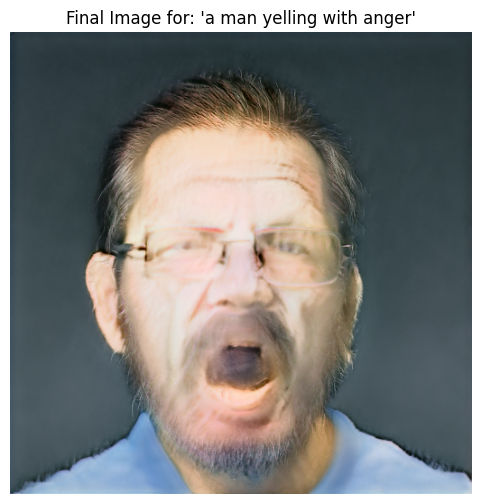

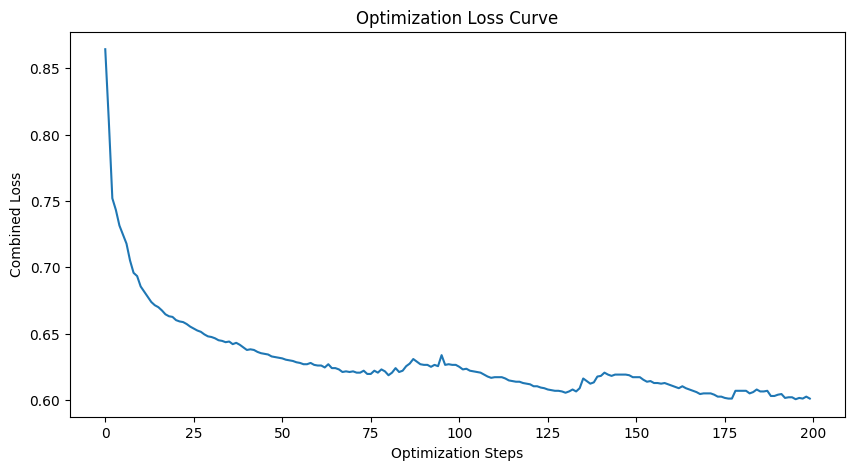

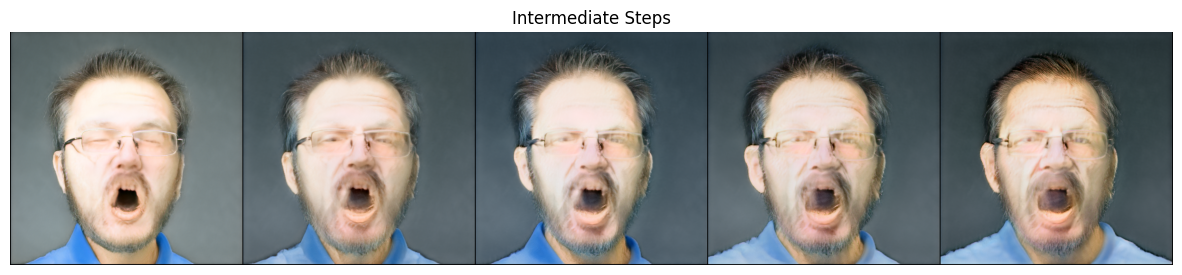

In [44]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm # Progress bar
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils


print(f"Starting optimization for '{target_text}'...")
print(f"Optimizing w vector for {n_steps} steps...")

# Store intermediate images and losses
intermediate_images = []
opt_losses = []
log_freq = 20 # How often to log loss and save image

pbar = tqdm(range(n_steps)) # Progress bar

for step in pbar:
    # Zero gradients for the optimizer manipulating w_opt
    optimizer_w.zero_grad()

    # Generate image from the current w_opt
    # Note: w_opt should have requires_grad=True
    img_gen = G_stylegan.synthesis(w_opt, noise_mode='const')

    # --- Calculate CLIP Loss (Image vs. Text) ---
    # Preprocess for CLIP: Upsample/Downsample to 224x224, shift range, normalize
    img_gen_clip_input = F.interpolate(img_gen, size=224, mode='bicubic', align_corners=False)
    img_gen_clip_input = (img_gen_clip_input + 1) / 2 # [-1,1] -> [0,1]
    img_gen_clip_input = clip_normalize(img_gen_clip_input)

    # Encode generated image
    embed_gen = clip_model.encode_image(img_gen_clip_input)
    embed_gen = embed_gen / embed_gen.norm(dim=-1, keepdim=True) # Normalize

    # Calculate loss against text embedding (want similarity -> minimize 1-cos_sim)
    loss_text = (1 - F.cosine_similarity(embed_gen, target_text_embedding)).mean() # .mean() if batch>1

    # --- Calculate DCGAN Influence Loss (Image vs. DCGAN Image Embedding) ---
    loss_dcgan = (1 - F.cosine_similarity(embed_gen, embed_dcgan)).mean() # .mean() if batch>1

    # --- Combine Losses ---
    total_loss = w_text * loss_text + w_dcgan * loss_dcgan

    # --- Backpropagate and Optimize W ---
    total_loss.backward() # Calculate gradients w.r.t. w_opt
    optimizer_w.step()   # Update w_opt

    # --- Logging and Visualization ---
    opt_losses.append(total_loss.item())
    pbar.set_description(f"Step {step+1}/{n_steps} | Total Loss: {total_loss.item():.4f} | Text Loss: {loss_text.item():.4f} | DCGAN Loss: {loss_dcgan.item():.4f}")

    if (step + 1) % log_freq == 0 or step == n_steps - 1:
         with torch.no_grad():
             img_vis = (img_gen.clamp(-1, 1) + 1) / 2
             intermediate_images.append(img_vis.cpu()) # Store for later viz/gif

print("\nOptimization finished.")

# --- Visualize Final Result and Loss Curve ---
print("Visualizing final result...")
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title(f"Final Image for: '{target_text}'")
plt.imshow(np.transpose(intermediate_images[-1][0], (1, 2, 0))) # Show first image in batch
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Optimization Loss Curve")
plt.plot(opt_losses)
plt.xlabel("Optimization Steps")
plt.ylabel("Combined Loss")
plt.show()

# You can also create a grid or animation from intermediate_images if desired
# Example: Displaying a few steps
grid_imgs = [intermediate_images[i] for i in range(0, len(intermediate_images), len(intermediate_images)//4)]
grid = vutils.make_grid(torch.cat(grid_imgs, dim=0), nrow=len(grid_imgs), padding=2, normalize=False)
plt.figure(figsize=(15, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.title("Intermediate Steps")
plt.show()

###Loading Diffusion Model

In [45]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image # For image handling if needed later

# --- Install/Upgrade Required Libraries ---
print("Installing/Updating diffusers, transformers, accelerate, scipy, safetensors...")
!pip install -q diffusers transformers accelerate scipy safetensors
print("Libraries installed/updated.")

# --- Load Stable Diffusion Image-to-Image Pipeline ---
# Ensure 'device' variable is set from previous cells (e.g., "cuda:0")
if 'device' not in locals():
     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
     print(f"Device was not set, detected: {device}")
else:
     print(f"Using device: {device}")

# Define the pre-trained model ID
# "runwayml/stable-diffusion-v1-5" is a popular choice. Others exist.
model_id = "runwayml/stable-diffusion-v1-5"
pipe_sd_img2img = None # Initialize to None

try:
    print(f"\nLoading Stable Diffusion Img2Img pipeline: {model_id}...")
    # Load the pipeline, using float16 for memory efficiency on GPU
    # This will download model weights (can be several GBs) if not cached.
    pipe_sd_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16, # Use half-precision for less VRAM usage
        use_safetensors=True      # Recommended for safety and compatibility
    )
    pipe_sd_img2img = pipe_sd_img2img.to(device)
    print("Stable Diffusion Img2Img pipeline loaded successfully and moved to device.")

    # Optional: Enable memory-efficient attention if desired/needed,
    # though it might not be necessary for single image inference if VRAM is sufficient.
    # pipe_sd_img2img.enable_attention_slicing()

except Exception as e:
    print(f"\nERROR loading Stable Diffusion pipeline: {e}")
    print("Ensure you have a stable internet connection and sufficient disk space/RAM.")
    print("If it's an authentication error, you might need to log in to Hugging Face Hub:")
    print("from huggingface_hub import notebook_login; notebook_login()")

Installing/Updating diffusers, transformers, accelerate, scipy, safetensors...
Libraries installed/updated.
Using device: cuda:0

Loading Stable Diffusion Img2Img pipeline: runwayml/stable-diffusion-v1-5...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Stable Diffusion Img2Img pipeline loaded successfully and moved to device.


###Diffusion Model Refinement

Preparing input image for diffusion refinement...
Input image (size: (512, 512)) ready for diffusion pipeline.

Running diffusion refinement with strength=0.5, guidance_scale=7.5...
Prompt: 'a man yelling with anger'


  0%|          | 0/25 [00:00<?, ?it/s]

Diffusion refinement complete.


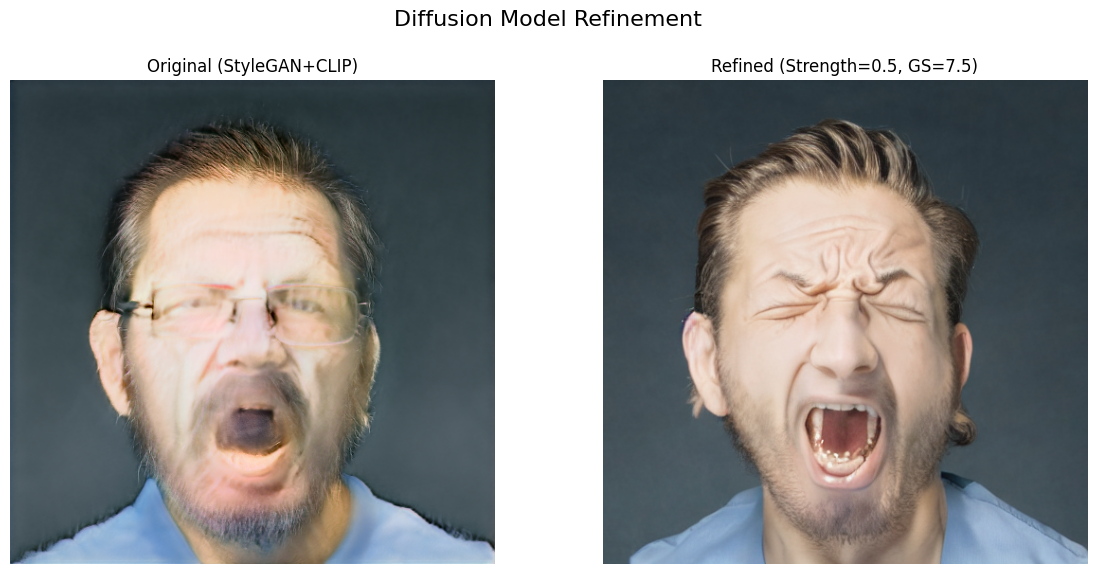

In [46]:
import torch
from torchvision.transforms.functional import to_pil_image # For converting tensor to PIL
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image # To ensure PIL is available

# --- Parameters for Diffusion Refinement ---
# Ensure target_text is the prompt used to generate the image in Phase 3
if 'target_text' not in locals():
    print("ERROR: 'target_text' variable not found. Please define it or re-run Phase 3 setup.")
    # target_text = "photo of a smiling woman with blonde hair" # Example if undefined
    # raise NameError("'target_text' not defined")


# Strength: 0.0-1.0. How much to transform the original image.
# Lower values = more similar to original. Higher values = more creative/different.
# Good starting range: 0.3 - 0.7
strength = 0.5

# Guidance Scale: How much the prompt guides the diffusion.
# Higher values = stronger adherence to prompt, but can reduce diversity/quality if too high.
# Typical values: 7.0 - 15.0
guidance_scale = 7.5

num_inference_steps = 50 # Number of diffusion steps (25-50 is common)

# Ensure pipe_sd_img2img is loaded and intermediate_images from Phase 3 exists
if 'pipe_sd_img2img' not in locals():
    print("ERROR: Stable Diffusion pipeline 'pipe_sd_img2img' not found. Please run the loading cell first.")
elif 'intermediate_images' not in locals() or not intermediate_images:
    print("ERROR: 'intermediate_images' not found or empty. Please generate an image using Phase 3 first.")
    print("If you have a saved image tensor, load it and assign to 'stylegan_output_tensor'.")
    # Example: stylegan_output_tensor = torch.randn(3, 512, 512) # Placeholder if needed
    # For now, we'll stop if the image isn't readily available
    raise NameError("'intermediate_images' not available from Phase 3.")
else:
    try:
        print("Preparing input image for diffusion refinement...")
        # Get the last generated image from the optimization loop (Phase 3)
        # This should be a tensor of shape [C, H, W] in range [0, 1]
        stylegan_output_tensor = intermediate_images[-1][0].cpu() # Get the single image, ensure on CPU

        # Convert the PyTorch tensor [0,1] to a PIL Image
        init_image_pil = to_pil_image(stylegan_output_tensor)
        print(f"Input image (size: {init_image_pil.size}) ready for diffusion pipeline.")

        print(f"\nRunning diffusion refinement with strength={strength}, guidance_scale={guidance_scale}...")
        print(f"Prompt: '{target_text}'")

        # Generate the refined image
        # Use torch.no_grad for inference
        with torch.no_grad():
            # The pipeline returns a list of images; we take the first one.
            refined_image_pil = pipe_sd_img2img(
                prompt=target_text,
                image=init_image_pil,
                strength=strength,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps
            ).images[0]

        print("Diffusion refinement complete.")

        # --- Visualize Original and Refined Images ---
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle('Diffusion Model Refinement', fontsize=16)

        # Original image from StyleGAN+CLIP
        axes[0].imshow(init_image_pil) # PIL image can be shown directly
        axes[0].set_title(f"Original (StyleGAN+CLIP)")
        axes[0].axis("off")

        # Refined image
        axes[1].imshow(refined_image_pil) # PIL image
        axes[1].set_title(f"Refined (Strength={strength}, GS={guidance_scale})")
        axes[1].axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except NameError as ne: # Catch if intermediate_images was truly not available
        print(f"Execution stopped due to NameError: {ne}")
        print("Please ensure the image from Phase 3 is available as 'intermediate_images[-1][0]'.")
    except Exception as e:
        print(f"An error occurred during diffusion refinement or visualization: {e}")
        import traceback
        traceback.print_exc()